In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import norm
from arch import arch_model


# Read data from yfinance 
ticker = '^DJA'
start = '1984-01-01'
end = '2024-04-01'
data = yf.download(ticker, start, end, interval='3mo')['Close']
price = data.values.flatten()
T = len(price)

# Create a date range and set frequency
date = pd.date_range(start='1984-01-01', periods=T, freq='3m')

# Initial settings for the SADF test window
r0 = 0.01 + 1.8 / np.sqrt(T)
swindow0 = int(np.floor(r0 * T))
dim = T - swindow0 + 1

# Generating log differences data for analysis
log_price = np.array(np.log(price))
delta_log_price = log_price[1:] - log_price[:-1]

date_diff = date[1:]
print(len(date))




[*********************100%%**********************]  1 of 1 completed

157


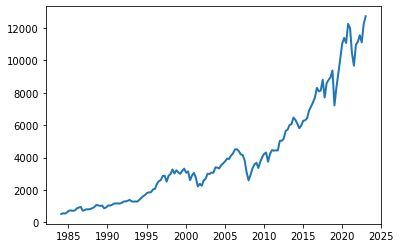

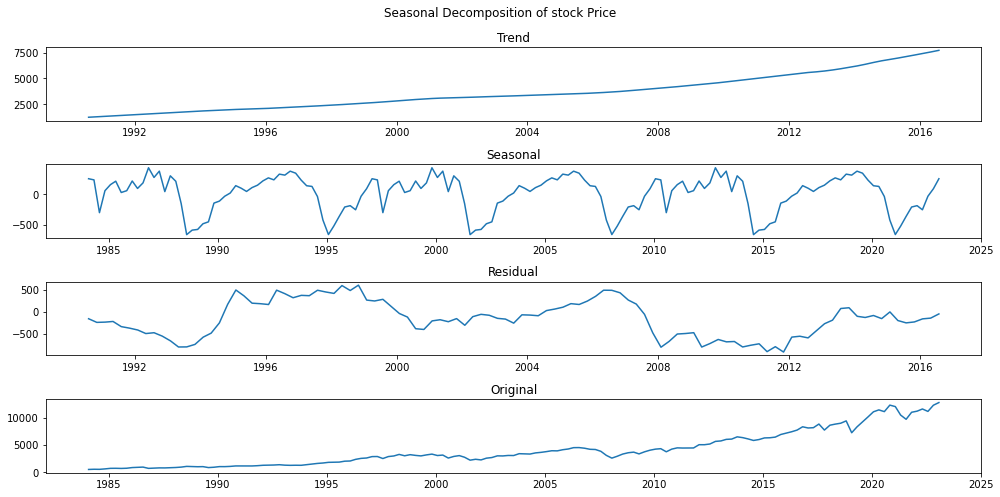

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


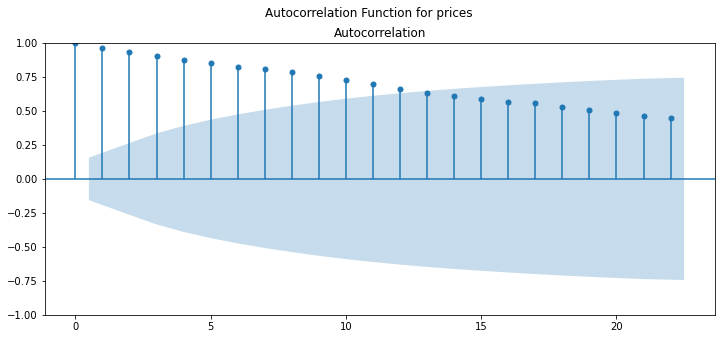

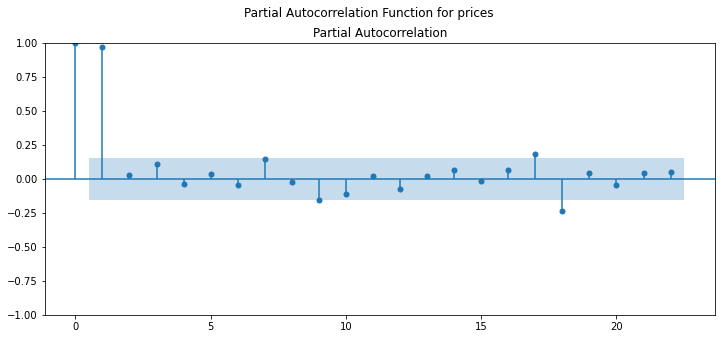

In [73]:

# Plotting the stock price level data
plt.figure(1)
plt.plot(date, price, linewidth=2)

decompositionp = seasonal_decompose(price, model = "additive", period = 52)

plt.figure(figsize=(14, 7))
plt.suptitle(f'Seasonal Decomposition of stock Price')
    
# Trend component
plt.subplot(411)
plt.plot(date, decompositionp.trend)
plt.title('Trend')
    
# Seasonal component
plt.subplot(412)
plt.plot(date, decompositionp.seasonal)
plt.title('Seasonal')
    
# Residual component
plt.subplot(413)
plt.plot(date, decompositionp.resid)
plt.title('Residual')
    
# Original Data
plt.subplot(414)
plt.plot(date, price)
plt.title('Original')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top spacing to accommodate the suptitle
plt.show()

# ACF and PACF

plt.figure(figsize=(12, 5))
plt.suptitle(f'Autocorrelation Function for prices')
plot_acf(price, ax=plt.gca())
    
plt.figure(figsize=(12, 5))
plt.suptitle(f'Partial Autocorrelation Function for prices')
plot_pacf(price, ax=plt.gca())
plt.show()

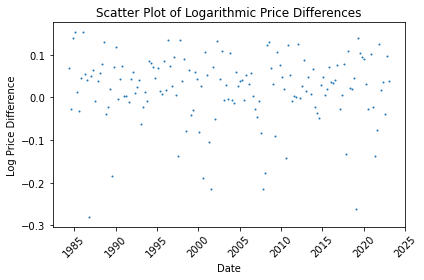

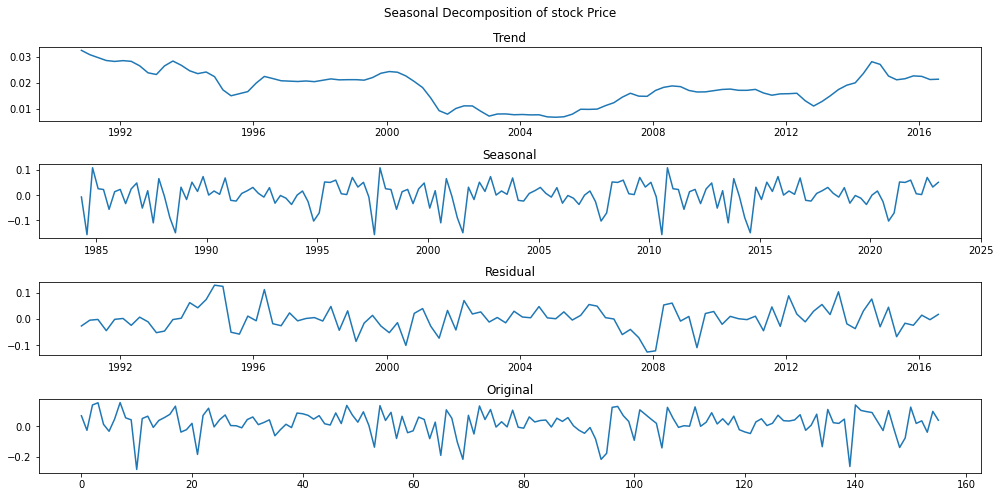

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


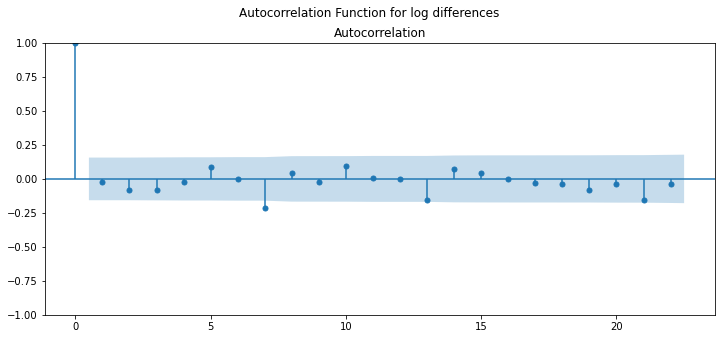

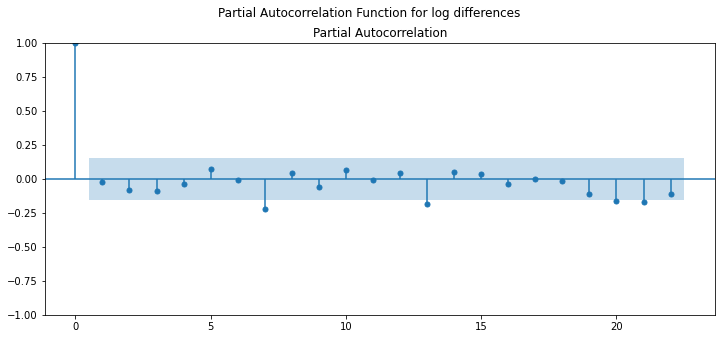

In [60]:
# Plotting the log differences data 
decompositionlog = seasonal_decompose(delta_log_price, model='additive', period=52)


# Creating a scatter plot for better visualization

plt.scatter(date_diff, delta_log_price, s = 1)
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Log Price Difference')  # Label for the y-axis
plt.title('Scatter Plot of Logarithmic Price Differences')  # Title of the plot
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated date labels
plt.show()

plt.figure(figsize=(14, 7))
plt.suptitle(f'Seasonal Decomposition of stock Price')
    
# Trend component
plt.subplot(411)
plt.plot(date_diff, decompositionlog.trend)
plt.title('Trend')
    
# Seasonal component
plt.subplot(412)
plt.plot(date_diff, decompositionlog.seasonal)
plt.title('Seasonal')
    
# Residual component
plt.subplot(413)
plt.plot(date_diff, decompositionlog.resid)
plt.title('Residual')
    
# Original Data
plt.subplot(414)
plt.plot(delta_log_price)
plt.title('Original')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top spacing to accommodate the suptitle
plt.show()

# ACF and PACF 
plt.figure(figsize=(12, 5))
plt.suptitle(f'Autocorrelation Function for log differences')
plot_acf(delta_log_price, ax=plt.gca())
    
plt.figure(figsize=(12, 5))
plt.suptitle(f'Partial Autocorrelation Function for log differences')
plot_pacf(delta_log_price, ax=plt.gca())
plt.show()


In [93]:
# Lag effect estimation Regression
def estimate_lag_effect(ts, lags):
    """
    Estimates the effect of lagged values on the current value of a time series.
    
    Parameters:
    - ts (pandas.Series or numpy.ndarray): The time series data.
    - lags (int): The number of lagged terms to include in the model. Must be non-negative.
    
    Returns:
    - result (RegressionResults): The regression results object from statsmodels.
    """
    if not isinstance(lags, int) or lags < 0:
        raise ValueError("lags must be a non-negative integer")

    if not isinstance(ts, pd.Series):
        ts = pd.Series(ts)
    
    if len(ts) <= lags:
        raise ValueError("Time series is too short relative to the number of lags requested")
    
    df = pd.concat([ts.shift(i) for i in range(lags + 1)], axis=1)
    df.columns = ['y'] + [f'lag_{i}' for i in range(1, lags + 1)]
    df = df.dropna()

    X = df.drop(columns='y')
    X = sm.add_constant(X)
    y = df['y']
    
    model = sm.OLS(y, X)
    result = model.fit()
    
    return result


In [105]:
def check_stationarity(ts):
    # Conduct the Augmented Dickey-Fuller test
    dftest = adfuller(ts, autolag='AIC')  # Using AIC to choose the best lag
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']  # Retrieving the critical value for 5% significance
    
    # Print results
    print(f'ADF Statistic: {adf}')
    print(f'p-value: {pvalue}')
    print(f'Critical Values at 5%: {critical_value}')
    
    # Evaluate stationarity based on the p-value and the ADF statistic
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.5065
Date:                Tue, 16 Apr 2024   Prob (F-statistic):              0.604
Time:                        18:55:51   Log-Likelihood:                 171.73
No. Observations:                 154   AIC:                            -337.5
Df Residuals:                     151   BIC:                            -328.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0225      0.007      3.284      0.0

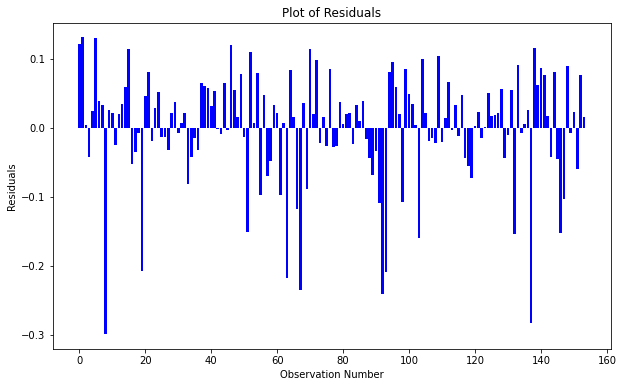

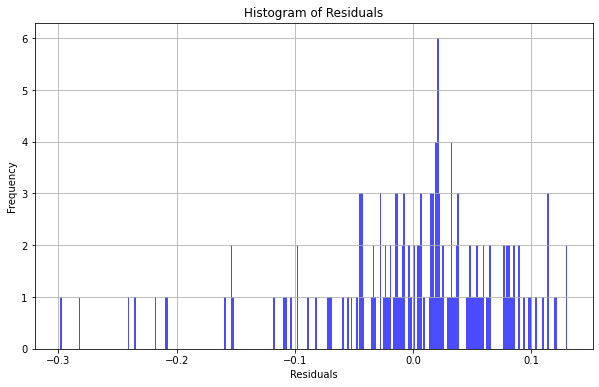

ADF Statistic: -12.394618087876859
p-value: 4.7055371383492216e-23
Critical Values at 5%: -2.880622899711496
The series is stationary


In [106]:
# Risiduals of lag effect regression
result = estimate_lag_effect(delta_log_price, lags=2)
print(result.summary())

residuals = result.resid

# Plotting the residuals on a bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(len(residuals)), residuals, color='blue')
plt.xlabel('Observation Number')
plt.ylabel('Residuals')
plt.title('Plot of Residuals')
plt.show()

# Plotting the residuals on a histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins= 300, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()

check_stationarity(residuals)

In [101]:
def analyze_residuals_for_heteroskedasticity(residuals, p=1, q=1):
    """
    Analyzes residuals for time-varying heteroskedasticity using a GARCH model.

    Parameters:
    - residuals (array-like): The residuals from a regression model.
    - p (int): The number of lagged variance terms to include in the model.
    - q (int): The number of lagged squared residual terms to include in the model.

    Returns:
    - arch_results (ARCHModelResult): The result from fitting the GARCH model.
    """
    # Fit a GARCH model
    arch_model = arch_model(residuals, mean='Zero', vol='Garch', p=p, q=q)
    arch_results = arch_model.fit(disp='off')
    
    return arch_results

In [76]:
def simulate_critical_values(num_simulations, T, r0):
    critical_values = []
    for _ in range(num_simulations):
        # Generate a unit root process
        series = np.random.normal(size=T).cumsum()
        # Placeholder for SADF/GSADF calculation: this should ideally be replaced
        # with a function that calculates the SADF/GSADF statistic.
        stat = adfuller(series, maxlag=int(r0*T), regression='c', autolag=None)[0]
        critical_values.append(stat)
    
    # Determine the 90%, 95%, and 99% critical values
    critical_values = np.percentile(critical_values, [90, 95, 99])
    return critical_values

# Example usage
num_simulations = 2000

critical_values = simulate_critical_values(num_simulations, T, r0)
print("Critical values at 90%, 95%, 99%:", critical_values)


Critical values at 90%, 95%, 99%: [-0.04883499  0.4308672   1.29941246]


In [77]:
# Calculate the SADF statistic
dateS = date[swindow0:]

badfs = np.zeros(dim)
for i in range(swindow0, T):
    result = adfuller(price[:i+1], maxlag=2, regression='c', autolag=None)
    badfs[i - swindow0] = result[0]
sadf = np.max(badfs)

print('The SADF statistic:', sadf)
print('The critical values:', critical_values)

The SADF statistic: 2.7631788715018977
The critical values: [-0.04883499  0.4308672   1.29941246]


In [78]:
# Calculate the Generalized SADF statistic
bsadfs = np.zeros(dim)
for r2 in range(swindow0, T):
    dim0 = r2 - swindow0 + 1
    rwadft = np.zeros(dim0)
    for r1 in range(dim0):
        result = adfuller(price[r1:r2+1], maxlag=2, regression='c', autolag=None)
        rwadft[r1] = result[0]
    bsadfs[r2 - swindow0] = np.max(rwadft)

gsadf = np.max(bsadfs)

print('The GSADF statistic:', gsadf)
print('The critical values:', critical_values)

The GSADF statistic: 3.5865693903218503
The critical values: [-0.04883499  0.4308672   1.29941246]


In [79]:
print(len(dateS), len(bsadfs), len(badfs)) 


133 134 134


In [80]:
# Removing excess values not in the date range
badfs_plt = badfs[:-1]
bsadfs_plt = bsadfs[:-1]


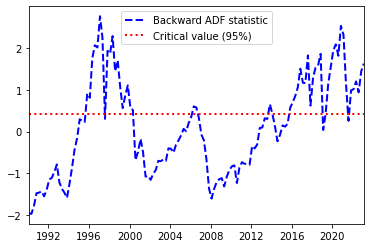

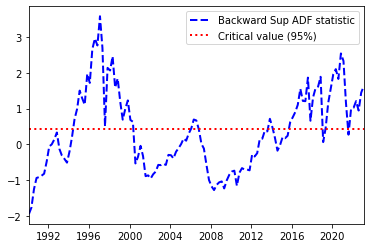

In [81]:
# Plot the backward ADF statistics
plt.figure(1)
plt.plot(dateS, badfs_plt, '--b', linewidth=2)
plt.plot(dateS, [critical_values[1]]*len(dateS), ':r', linewidth=2)
plt.xlim([dateS[0], dateS[-1]])
plt.legend(['Backward ADF statistic', 'Critical value (95%)'])



# Plot the Generalized SADF statistics
plt.figure(2)
plt.plot(dateS, bsadfs_plt, '--b', linewidth=2)
plt.plot(dateS, [critical_values[1]]*len(dateS), ':r', linewidth=2)
plt.xlim([dateS[0], dateS[-1]])
plt.legend(['Backward Sup ADF statistic', 'Critical value (95%)'])
